参考：[隠れマルコフモデルをざっくり理解したい](https://qiita.com/s-kojima1227/items/36e2468570c9bc62a481)

In [2]:
import numpy as np
import numpy.linalg as LA
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [122]:
# モデルの自由度
K = 2
D = 6

# 遷移確率 A[ki, kj] = p( z_{n+1,kj}=1 | z_{n,ki}=1 )
# 潜在変数で条件づけられた観測変数の出力確率 B[k, t] = p( x_n=t | z_n=k )
# 混合係数 pi[k] = p(z_{0,k}=1)

A_transition = np.array([
    [0.9, 0.1],
    [0.1, 0.9]
])

B_emission = np.array([
    [1./6.]*6,
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]
])

pi = np.array(
    [1., 0.]
)

# 繰り返し回数のパラメータ
T = 100
EPSILON = 1e-5

# 観測データ列
x = np.array([
    4, 4, 5, 4, 2, 3, 3, 6, 4, 5, 5, 3, 4, 4, 1, 4, 5, 3, 6, 5,
    3, 3, 3, 5, 5, 3, 5, 6, 5, 5, 1, 3, 4, 3, 1, 2, 6, 1, 6, 1,
    5, 4, 2, 4, 1, 5, 4, 1, 1, 1, 1, 5, 6, 6, 6, 6, 1, 6, 2, 6,
    2, 6, 1, 6, 6, 6, 6, 6, 3, 2, 6, 6, 6, 1, 6, 6, 2, 6, 6, 5,
    6, 6, 5, 6, 6, 6, 6, 4, 3, 6, 6, 5, 2, 5, 4, 5, 6, 5, 4, 4
])
for i in range(x.shape[0]):
    x[i] -= 1

In [20]:
def forward(x, A_transition, B_emission, pi):
    N = x.shape[0]
    # K = A_transition.shape[0]
    # D = B_emission.shape[1]
    alpha = np.zeros((N, K))
    c = np.zeros(N) # alphaは値が小さくなりすぎるのでスケーリングが必要（prml 13.2.4節）

    alpha[0, :] = pi * B_emission[:, x[0]]
    c[0] = np.sum(alpha[0, :])
    alpha[0, :] /= c[0]

    for n in range(1, N):
        for k in range(K):
            alpha[n, k] = B_emission[k, x[n]] * np.sum(alpha[n-1, :] * A_transition[:, k])
        c[n] = np.sum(alpha[n, :])
        alpha[n, :] /= c[n]

    return alpha, c

In [186]:
def backward(x, A_transition, B_emission, pi, c):
    N = x.shape[0]
    # K = A_transition.shape[0]
    # D = B_emission.shape[1]
    beta = np.zeros((N, K))
    beta[N-1, :] = 1.

    for n in reversed(range(N-1)):
        for k in range(K):
            beta[n, k] = np.sum(beta[n+1, :] * B_emission[:, x[n+1]] * A_transition[k, :])
        beta[n, :] /= c[n+1]

        for k in range(K):
            if beta[n, k] - beta[n+1, k] > 1.:
                beta[n, k] = 1.

    return beta

In [29]:
def E_step(x, A_transition, B_emission, pi):
    N = x.shape[0]
    # K = A_transition.shape[0]
    # D = B_emission.shape[1]
    alpha, c = forward(x, A_transition, B_emission, pi)
    beta = backward(x, A_transition, B_emission, pi, c)
    likelihood = np.sum(np.log(c))

    gamma = np.zeros((N, K))
    xi = np.zeros((N-1, K, K))

    for n in range(N):
        gamma[n, :] = alpha[n, :] * beta[n, :] / np.sum(alpha[n, :] * beta[n, :])
        if n == N-1:
            break
        for i in range(K):
            for j in range(K):
                xi[n, i, j] = alpha[n, i] * A_transition[i, j] * B_emission[j, x[n+1]] * beta[n+1, j]
        xi[n, :, :] /= np.sum(xi[n, :, :])

    return alpha[:, 1], beta[:, 1], gamma, xi, likelihood

In [30]:
def M_step(x, gamma, xi):
    N = x.shape[0]
    A_new = np.zeros((K, K))
    B_new = np.zeros((K, D))
    pi_new = gamma[0, :]

    for i in range(K):
        for j in range(K):
            A_new[i, j] = np.sum(xi[:-1, i, j])
        A_new[i, :] /= np.sum(gamma[:-1, i])

        for d in range(D):
            for n in range(N):
                B_new[i, d] += (x[n] == d) * gamma[n, i]
        B_new[i, :] /= np.sum(gamma[:, i])

    return A_new, B_new, pi_new

In [109]:
def EM(x, A_transition, B_emission, pi):
    N = x.shape[0]
    likelihood = -np.inf
    for t in range(T):
        alpha, beta, gamma, xi, likelihood_new = E_step(x, A_transition, B_emission, pi)
        A_new, B_new, pi_new = M_step(x, gamma, xi)

        if t%5 == 0:
            print(f"likelihood={likelihood_new}")
        if t==T-1 or np.abs(likelihood_new - likelihood) < EPSILON:
            print(f"t={t}: {likelihood} -> {likelihood_new}")
            break

        A_transition = A_new
        B_emission = B_new
        pi = pi_new
        likelihood = likelihood_new

    return A_transition, B_emission, pi, alpha, beta, gamma[:, 1]

likelihood=-130.45901182015677
likelihood=-169.38693517605037
likelihood=-169.02435874092006
likelihood=-168.30392746071158
likelihood=-166.84544993882636
likelihood=-163.59277826840773
likelihood=-159.29577518757134
likelihood=-157.7754324563515
likelihood=-155.03030530171424
likelihood=-154.5391216383622
likelihood=-154.62932934912007
t=54: -154.62943901933872 -> -154.62944369248362
A : p(z_n|z_n-1)
[[0.96993463 0.01028144]
 [0.02658316 0.98110802]]
B : p(x_n|z_n)
[[1.51643937e-01 6.07631751e-02 1.68901852e-01 2.30379627e-01
  2.60156856e-01 1.28154553e-01]
 [8.96092849e-02 1.15898695e-01 2.87420771e-02 5.60973975e-11
  5.90771676e-02 7.06672775e-01]]
pi
[1.00000000e+000 3.85998418e-235]


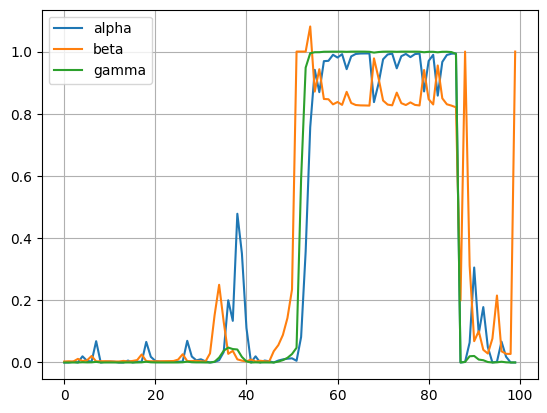

In [202]:
A_transition = np.random.rand(K, K)
B_emission = np.random.rand(K, D)
pi = np.random.rand(K)

A_est, B_est, pi_est, alpha, beta, gamma = EM(x, A_transition, B_emission, pi)
print(f"A : p(z_n|z_n-1)\n{A_est}")
print(f"B : p(x_n|z_n)\n{B_est}")
print(f"pi\n{pi_est}")

ax = plt.subplot(111)
n = range(x.shape[0])
ax.plot(n, alpha, label="alpha")
ax.plot(n, beta, label="beta")
ax.plot(n, gamma, label="gamma")
ax.legend()
ax.grid()

In [185]:
beta

array([0.00938048, 0.01154124, 0.00940899, 0.03365513, 0.01306216,
       0.02005828, 0.06263801, 0.01024476, 0.01212295, 0.01194171,
       0.01100607, 0.00940692, 0.00938055, 0.0150356 , 0.00945411,
       0.01454298, 0.02247881, 0.07731205, 0.01303746, 0.01155646,
       0.01138616, 0.01149396, 0.01232033, 0.01266353, 0.01410975,
       0.02774393, 0.0796741 , 0.01354514, 0.01338251, 0.01612719,
       0.01110875, 0.00942319, 0.08621788, 0.45558246, 0.74530922,
       0.39934452, 0.08726358, 0.11497205, 0.0340316 , 0.01927956,
       0.01086751, 0.02724526, 0.00961305, 0.01633815, 0.01163159,
       0.00942786, 0.13991412, 0.21821583, 0.34802773, 0.56343432,
       0.92099455, 3.91946152, 2.91946152, 1.91946152, 1.02663994,
       0.8692596 , 0.93406291, 0.85369331, 0.85548522, 0.8399148 ,
       0.84818569, 0.83852934, 0.88194681, 0.84463584, 0.83806052,
       0.83688625, 0.83658865, 0.83602102, 0.99745526, 0.93127682,
       0.85331256, 0.83956126, 0.83703951, 0.87941321, 0.84417